## Text Classification - Natural Language Processing

Text classification also known as *text tagging* or *text categorization* is the process of categorizing text into organized groups. By using Natural Language Processing (NLP), text classifiers can automatically analyze text and then assign a set of pre-defined tags or categories based on its content.

This notebook gives a brief overview of performing ***literature text tagging*** using Naive Bayes, Logistic Regression, Support Vector Machines and Decision Tree Classifier. The data consists of approximately 1500 text pieces, which were tagged as ***cult***, ***paranormal***, and ***dramatic***. Our goal in this kernel is to explore the process of training and testing text classifiers for this dataset.

![Text Classification](https://www.dataquest.io/wp-content/uploads/2019/04/text-classification-python-spacy.png)

### Import Required Libraries

In [41]:
import sys
import nltk
import sklearn
import pandas as pd
import numpy as np

# import matplotlib as mpl 
# import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from plotly.offline import init_notebook_mode
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import spacy

from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords

from nltk.classify.scikitlearn import SklearnClassifier



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics



from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from time import time

# import warnings
# warnings.filterwarnings("ignore")

from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

tqdm.pandas()

lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

## Analysis of Data

In [42]:
data = pd.read_csv('../Data/task.csv', encoding='utf-8')
data.head()

,Unnamed: 0,Title,Synopsis,Tag
0,0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,cult
1,1,Mitt liv som hund,The action takes place in the years 1958-1959 ...,cult
2,2,The Brood,"At the Somafree Institute, Dr. Hal Raglan humi...",cult
3,3,The Haunted,This creepy and scary story centers around The...,paranormal
4,4,The Frozen Ground,The film opens in an Anchorage motel room in 1...,dramatic


In [43]:
round(data["Tag"].value_counts()/len(data), 2)

cult          0.66
paranormal    0.23
dramatic      0.11
Name: Tag, dtype: float64

There is an imbalance in the data with cultt being 66% in the dataset. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into numeric outcome variables for our ML methods.

In [44]:
fig = go.Figure([go.Bar(x=data['Tag'].value_counts().index, y=data['Tag'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1566 non-null   int64 
 1   Title       1566 non-null   object
 2   Synopsis    1566 non-null   object
 3   Tag         1566 non-null   object
dtypes: int64(1), object(3)
memory usage: 49.1+ KB


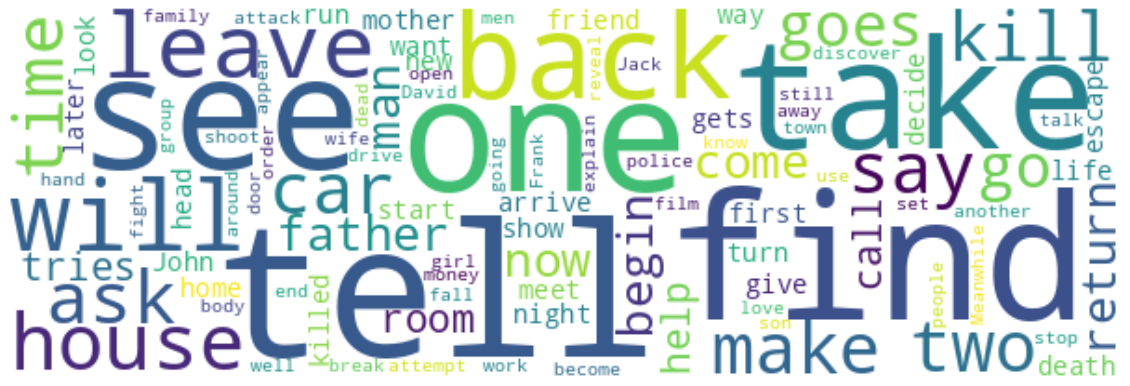

In [46]:
wordcloud = WordCloud(max_words=100, width=600, background_color='white').generate(" ".join(data['Synopsis']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Text Pre-processing

In [47]:
# tags = [ 0 if x=='cult'  else 1 if x=='paranormal' else 2 for x in data['Tag']]
# data['Tag'] = tags
# round(data["Tag"].value_counts()/len(data), 2)

In [48]:
enc = LabelEncoder()
label = enc.fit_transform(data['Tag'])
data['Tag'] = label
round(data["Tag"].value_counts()/len(data), 2)

0    0.66
2    0.23
1    0.11
Name: Tag, dtype: float64

In [49]:
data.head()

,Unnamed: 0,Title,Synopsis,Tag
0,0,I tre volti della paura,Note: this synopsis is for the orginal Italian...,0
1,1,Mitt liv som hund,The action takes place in the years 1958-1959 ...,0
2,2,The Brood,"At the Somafree Institute, Dr. Hal Raglan humi...",0
3,3,The Haunted,This creepy and scary story centers around The...,2
4,4,The Frozen Ground,The film opens in an Anchorage motel room in 1...,1


In [50]:
data['Synopsis'][0]

'Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the \'Three Faces of Fear\'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has recently escaped from prison. Rosy is terrified for it was her testimony that landed the man in jail. Looking for solace, Rosy phones her lesbian lover Mary (Lynda Alfonsi). The two women have been estranged for some time, but Rosy is certain that she is the only one who can help her. Mary agrees to come over that night. Seconds later, Frank calls again, promising that no matter who she calls for protection, he will have his revenge. Unknown to Rosy, Mary is the caller impersonating Frank. Marry

### Text Cleaning

Using regular expression to cleanup the texs

In [51]:
text = data['Synopsis']
# Replace email addresses with 'email'
processed = text.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', regex=True)

# Replace URLs with 'webaddress'
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                  'webaddress', regex=True)

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
processed = processed.str.replace(r'£|\$', 'moneysymb', regex=True)
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                  'phonenumbr', regex=True)
    
# Replace numbers with 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)

# Removeing useless characters like whitespace, punctuation and so on
processed = processed.str.replace(r'[^\w\d\s]', ' ', regex=True)

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ', regex=True)

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '', regex=True)

Lower case sentence

In [52]:
processed = processed.str.lower()
processed

0       note this synopsis is for the orginal italian ...
1       the action takes place in the years numbr numb...
2       at the somafree institute dr hal raglan humili...
3       this creepy and scary story centers around the...
4       the film opens in an anchorage motel room in n...
                              ...                        
1561    buck o brien mike white is a numbr year old am...
1562    american foreign news correspondent larry stan...
1563    two children jacques mayol jean marc barr and ...
1564    bernard chanticleer peter kastner called big b...
1565    petey wheatstraw rudy ray moore is born during...
Name: Synopsis, Length: 1566, dtype: object

Removeing stopwords from the text by using the list from NLTK.

In [53]:
# In case you do not have the stopwords already, you can run the below line
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/amin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [54]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

Using PorterStemmer, we can extract stem of each word.


In [55]:
ps = nltk.PorterStemmer()

processed = processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

In [56]:
processed

0       note synopsi orgin italian releas segment cert...
1       action take place year numbr numbr sweden trou...
2       somafre institut dr hal raglan humili patient ...
3       creepi scari stori center around smurl famili ...
4       film open anchorag motel room numbr numbr year...
                              ...                        
1561    buck brien mike white numbr year old amateur p...
1562    american foreign news correspond larri stanfor...
1563    two children jacqu mayol jean marc barr enzo m...
1564    bernard chanticl peter kastner call big boy pa...
1565    petey wheatstraw rudi ray moor born great miam...
Name: Synopsis, Length: 1566, dtype: object

In [57]:
processed[0]

'note synopsi orgin italian releas segment certain order bori karloff introduc three horror tale macabr supernatur known three face fear telephonerosi michel mercier attract high price parisian call girl return spaciou basement apart even immedi get beset seri strang phone call caller soon identifi frank ex pimp recent escap prison rosi terrifi testimoni land man jail look solac rosi phone lesbian lover mari lynda alfonsi two women estrang time rosi certain one help mari agre come night second later frank call promis matter call protect reveng unknown rosi mari caller imperson frank marri arriv rosi apart soon best calm rosi nerv give panic struck woman tranquil put bed later night rosi sleep mari get bed pen note confess one make strang phone call learn frank escap prison know rosi would call help explain felt way come back life breakup busi write fail notic intrud apart time frank real creep behind mari strangl death one rosi nylon stock sound struggl awaken rosi gasp fright murder p

### Feature extraction

After preprocessing, we need to extract feature from text message. To do this, it will be necessary to tokenize each words.

***In case of error while runing tokenizer that you do not have the punkt package, you can run the below line.***


In [58]:
# nltk.download('punkt')

In [59]:
# from nltk.tokenize import word_tokenize

# all_words = []

# for message in processed:
#     words = word_tokenize(message)
#     for w in words:
#         all_words.append(w)

# all_words_freq = nltk.FreqDist(all_words)

# # Print the result
# print('Number of words: {}'.format(len(all_words_freq)))
# print('Most common words: {}'.format(all_words_freq.most_common(15)))

In [60]:
# list(all_words_freq.keys())[:20]

Based on the below analysis length of feature vector will be around the median (2350.5). We select the lenght 2400 for simplisity.


In [35]:

textlenght = [len(x) for x in processed]
# textlenght
app = Dash("lenght of Synopsis text analysis")

app.layout = html.Div([
    html.H4("Analysis of Synopsis text"),
    html.P("Select Distribution:"),
    dcc.RadioItems(
        id='distribution',
        options=['box', 'violin', 'rug'],
        value='box', inline=True
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("distribution", "value"))
def display_graph(distribution):
    df = px.data.tips() # replace with your own data source
    fig = px.histogram(
        textlenght,
        marginal=distribution,
)
    return fig


app.run_server(debug=True)

Now we are ready for the modeling. We are going to use algorithms from sklearn package. We will go through the following steps:

1. Split the data into training and test sets (80% train, 20% test)
2. Extract features from the training data using TfidfVectorizer.
3. Transform the test data into the same feature vector as the training data.
4. Train the classifier
5. Evaluate the classifier

## TF-IDF Vectorizer

![TF-IDF](https://miro.medium.com/max/3136/1*ruCawEw0--m2SeHmAQooJQ.jpeg)

In [21]:
docs = list(processed)
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 2400) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [22]:
X = docs 
y = data['Tag']
print(X.shape, y.shape)

(1566, 2400) (1566,)


In [23]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

### Train-Test Split

In [24]:

X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1252, 2400) (1252,)
(314, 2400) (314,)


## Naive Bayes Classifier

### Gaussian Naive Bayes

In [25]:
gnb = GaussianNB() 
%time gnb.fit(X_train, y_train)

y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 69.2 ms, sys: 8.11 ms, total: 77.3 ms
Wall time: 47.9 ms

Training Accuracy score: 0.884185303514377
Testing Accuracy score: 0.5987261146496815


In [26]:
print(classification_report(y_test, y_pred_test, target_names=['Cult', 'paranormal', 'dramatic']))

              precision    recall  f1-score   support

        Cult       0.71      0.73      0.72       207
  paranormal       0.18      0.09      0.12        34
    dramatic       0.40      0.45      0.42        73

    accuracy                           0.60       314
   macro avg       0.43      0.42      0.42       314
weighted avg       0.58      0.60      0.59       314



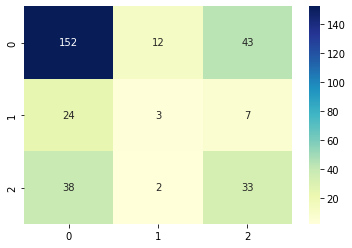

In [27]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Gaussian Naive Bayes performs poorly in this case because of the prior and posterior probability condition

### Multinomial Naive Bayes

In [28]:
mnb = MultinomialNB() 
%time mnb.fit(X_train, y_train)

y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 30.1 ms, sys: 6.48 ms, total: 36.6 ms
Wall time: 9.13 ms

Training Accuracy score: 0.7188498402555911
Testing Accuracy score: 0.6592356687898089


In [29]:
print(classification_report(y_test, y_pred_test, target_names=['Cult', 'paranormal', 'dramatic']))

              precision    recall  f1-score   support

        Cult       0.66      0.99      0.79       207
  paranormal       0.00      0.00      0.00        34
    dramatic       0.50      0.03      0.05        73

    accuracy                           0.66       314
   macro avg       0.39      0.34      0.28       314
weighted avg       0.55      0.66      0.53       314



/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



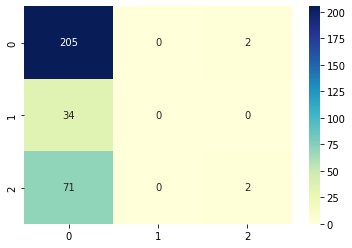

In [30]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

Multinomial Naive Bayes performs slightly worse than Gaussian Naive Bayes, because the size of feature vector is really big and Bayes Algorythm works better for small number of features. Let's check out results of Logistic Regression, Support Vector Machines and Decision Tree Classifier.

## Logistic Regression Classifier

In [31]:
lr = LogisticRegression()
%time lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 1.06 s, sys: 1.35 s, total: 2.42 s
Wall time: 395 ms

Training Accuracy score: 0.8154952076677316
Testing Accuracy score: 0.6910828025477707


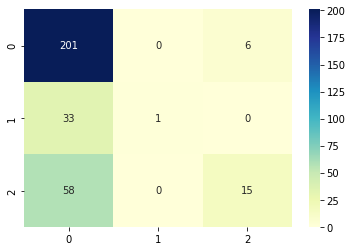

In [32]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [33]:
print(classification_report(y_test, y_pred_test, target_names=['Cult', 'paranormal', 'dramatic']))

              precision    recall  f1-score   support

        Cult       0.69      0.97      0.81       207
  paranormal       1.00      0.03      0.06        34
    dramatic       0.71      0.21      0.32        73

    accuracy                           0.69       314
   macro avg       0.80      0.40      0.39       314
weighted avg       0.73      0.69      0.61       314



## Support Vector Machines

In [34]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 75.9 ms, sys: 11 µs, total: 75.9 ms
Wall time: 75 ms

Training Accuracy score: 0.9840255591054313
Testing Accuracy score: 0.6751592356687898


/home/amin/.local/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning:

The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.



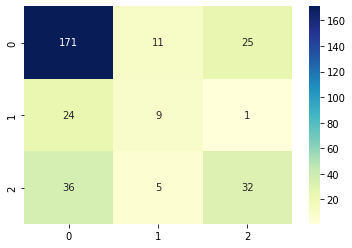

In [35]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [36]:
print(classification_report(y_test, y_pred_test, target_names=['Cult', 'paranormal', 'dramatic']))

              precision    recall  f1-score   support

        Cult       0.74      0.83      0.78       207
  paranormal       0.36      0.26      0.31        34
    dramatic       0.55      0.44      0.49        73

    accuracy                           0.68       314
   macro avg       0.55      0.51      0.52       314
weighted avg       0.66      0.68      0.66       314



## Decision Tree Classifier

In [37]:

dt = DecisionTreeClassifier()
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 1.37 s, sys: 5.38 ms, total: 1.38 s
Wall time: 1.36 s

Training Accuracy score: 0.9960063897763578
Testing Accuracy score: 0.6050955414012739


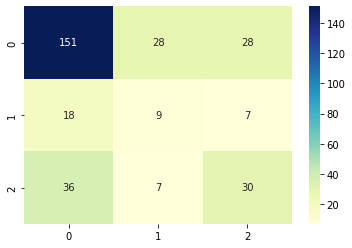

In [38]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, )
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [39]:
print(classification_report(y_test, y_pred_test, target_names=['Cult', 'paranormal', 'dramatic']))

              precision    recall  f1-score   support

        Cult       0.74      0.73      0.73       207
  paranormal       0.20      0.26      0.23        34
    dramatic       0.46      0.41      0.43        73

    accuracy                           0.61       314
   macro avg       0.47      0.47      0.47       314
weighted avg       0.62      0.61      0.61       314



################
### K Nearest Neighbors
################
Training Accuracy score: 0.7292332268370607
Testing Accuracy score: 0.6560509554140127


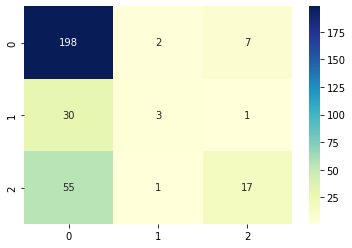

              precision    recall  f1-score   support

        Cult       0.69      0.91      0.78       207
  paranormal       0.36      0.12      0.18        34
    dramatic       0.48      0.19      0.27        73

    accuracy                           0.66       314
   macro avg       0.51      0.41      0.41       314
weighted avg       0.60      0.66      0.60       314

################
### Decision Tree
################
Training Accuracy score: 0.9960063897763578
Testing Accuracy score: 0.5955414012738853


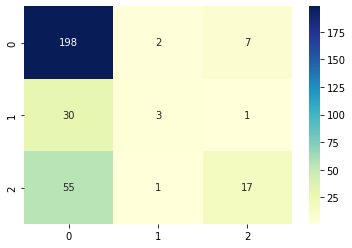

              precision    recall  f1-score   support

        Cult       0.72      0.74      0.73       207
  paranormal       0.17      0.18      0.17        34
    dramatic       0.42      0.38      0.40        73

    accuracy                           0.60       314
   macro avg       0.44      0.43      0.43       314
weighted avg       0.59      0.60      0.59       314

################
### Random Forest
################
Training Accuracy score: 0.9960063897763578
Testing Accuracy score: 0.6910828025477707


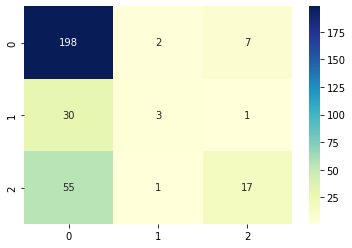

              precision    recall  f1-score   support

        Cult       0.69      0.98      0.81       207
  paranormal       0.00      0.00      0.00        34
    dramatic       0.71      0.21      0.32        73

    accuracy                           0.69       314
   macro avg       0.47      0.39      0.38       314
weighted avg       0.62      0.69      0.61       314



/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



################
### Logistic Regression
################
Training Accuracy score: 0.8154952076677316
Testing Accuracy score: 0.6910828025477707


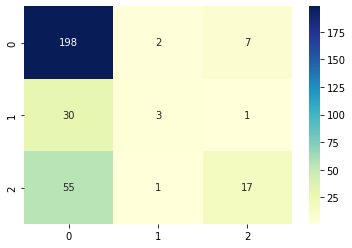

              precision    recall  f1-score   support

        Cult       0.69      0.97      0.81       207
  paranormal       1.00      0.03      0.06        34
    dramatic       0.71      0.21      0.32        73

    accuracy                           0.69       314
   macro avg       0.80      0.40      0.39       314
weighted avg       0.73      0.69      0.61       314

################
### SGD Classifier
################
Training Accuracy score: 0.994408945686901
Testing Accuracy score: 0.6592356687898089


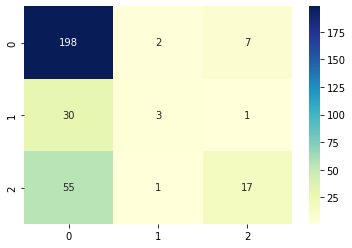

              precision    recall  f1-score   support

        Cult       0.72      0.84      0.77       207
  paranormal       0.50      0.15      0.23        34
    dramatic       0.46      0.38      0.42        73

    accuracy                           0.66       314
   macro avg       0.56      0.46      0.47       314
weighted avg       0.63      0.66      0.63       314

################
### Naive Bayes
################
Training Accuracy score: 0.7188498402555911
Testing Accuracy score: 0.6592356687898089


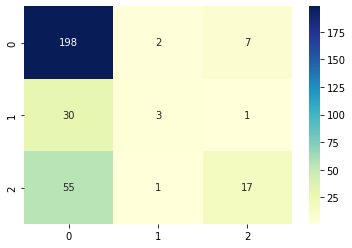

              precision    recall  f1-score   support

        Cult       0.66      0.99      0.79       207
  paranormal       0.00      0.00      0.00        34
    dramatic       0.50      0.03      0.05        73

    accuracy                           0.66       314
   macro avg       0.39      0.34      0.28       314
weighted avg       0.55      0.66      0.53       314



/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/amin/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



################
### Support Vector Classifier
################
Training Accuracy score: 0.8785942492012779
Testing Accuracy score: 0.7006369426751592


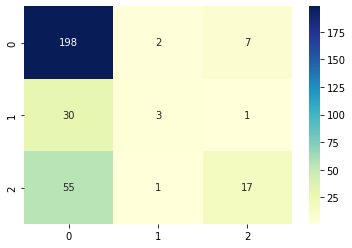

              precision    recall  f1-score   support

        Cult       0.70      0.96      0.81       207
  paranormal       0.33      0.03      0.05        34
    dramatic       0.72      0.29      0.41        73

    accuracy                           0.70       314
   macro avg       0.59      0.42      0.43       314
weighted avg       0.67      0.70      0.64       314



In [44]:

names = ['K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'SGD Classifier',
         'Naive Bayes', 'Support Vector Classifier']

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter=100),
    MultinomialNB(),
    SVC(kernel='linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    model.fit(X_train, y_train)
    y_pred_train= model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("################\n### %s\n################"%name)
    print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
    print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
    cm = confusion_matrix(y_test, y_pred_test)
    
    cm_matrix = pd.DataFrame(data=cm, )
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()
    print(classification_report(y_test, y_pred_test, target_names=['Cult', 'paranormal', 'dramatic']))

## Ensembleing

################
### Ensemble method
################
Training Accuracy score: 0.9001597444089456
Testing Accuracy score: 0.6910828025477707


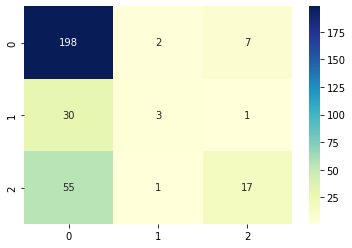

              precision    recall  f1-score   support

        Cult       0.69      0.97      0.81       207
  paranormal       1.00      0.03      0.06        34
    dramatic       0.71      0.21      0.32        73

    accuracy                           0.69       314
   macro avg       0.80      0.40      0.39       314
weighted avg       0.73      0.69      0.61       314



In [46]:
models = list(zip(names, classifiers))

ensemble = VotingClassifier(estimators=models, voting='hard', n_jobs=-1)
ensemble.fit(X_train, y_train)
y_pred_train= ensemble.predict(X_train)
y_pred_test = ensemble.predict(X_test)
print("################\n### %s\n################"%'Ensemble method')
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data=cm, )
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()
print(classification_report(y_test, y_pred_test, target_names=['Cult', 'paranormal', 'dramatic']))


So, how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "paranormal", and "dramatic" texts. If we choose purely based on how good it is doing with "paranormal", and "dramatic" category, we should choose the Decesion Tree or VotingClassifier (Ensembleing) we built.


In [276]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [277]:
y = data['Tag']

Train - Test Splitting (80:20)


In [278]:

X_train,X_test,y_train,y_test=train_test_split(processed, y, test_size=0.2, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1252,) (1252,)
(314,) (314,)


In [279]:
y_train = tf.keras.utils.to_categorical(
    y_train, num_classes=None, dtype='float32'
)
y_val = tf.keras.utils.to_categorical(
    y_test, num_classes=None, dtype='float32'
)


## Tokenization
 . Splitting sentences into words
 
 . Finding the vocab size

In [280]:
max_len = 2000     
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  25777


In [281]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

In [282]:
# X_train

## Multi-Headed Attention
 . Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension.

. The Self Attention mechanism (illustrated in picture above next to the picture of encoder block) is used several times in parallel in Multi-Head attention

. Multiple attention heads allows for attending to parts of the sequence differently

 . During self attention a word's attention score with itself will be the highest, therefore by using mutli-head attention a word can establish its relationship with other words in the sequence by calculating the attention scores with them in parallel

In [283]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Model definition

In [284]:
embed_dim = 20 
heads = 2  
neurons = 10
# maxlen = 2000
# vocab_size = vocab_size

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
outputs = layers.Dense(3, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [285]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 20)          519540    
 g_23 (TokenAndPositionEmbed                                     
 ding)                                                           
                                                                 
 transformer_encoder_23 (Tra  (None, 200, 20)          3850      
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_23  (None, 20)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_71 (Dropout)        (None, 20)                0  

In [286]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.0001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [298]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test,y_val),
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
40/40 [==============================] - 1s 25ms/step - loss: 0.5126 - accuracy: 0.6597 - val_loss: 0.5111 - val_accuracy: 0.6592
Epoch 2/25
40/40 [==============================] - 1s 24ms/step - loss: 0.5101 - accuracy: 0.6597 - val_loss: 0.5088 - val_accuracy: 0.6592
Epoch 3/25
40/40 [==============================] - 1s 25ms/step - loss: 0.5037 - accuracy: 0.6597 - val_loss: 0.5075 - val_accuracy: 0.6592
Epoch 4/25
40/40 [==============================] - 1s 25ms/step - loss: 0.4954 - accuracy: 0.6597 - val_loss: 0.5055 - val_accuracy: 0.6592
Epoch 5/25
40/40 [==============================] - 1s 24ms/step - loss: 0.4923 - accuracy: 0.6597 - val_loss: 0.5039 - val_accuracy: 0.6592
Epoch 6/25
40/40 [==============================] - 1s 25ms/step - loss: 0.4900 - accuracy: 0.6597 - val_loss: 0.5020 - val_accuracy: 0.6592
Epoch 7/25
40/40 [==============================] - 1s 24ms/step - loss: 0.4802 - accuracy: 0.6597 - val_loss: 0.4999 - val_accuracy: 0.6592
Epoch 8/25
40

## Model Evaluation

***Learning Curves***

 . Loss Curve

 . Accuracy Curve

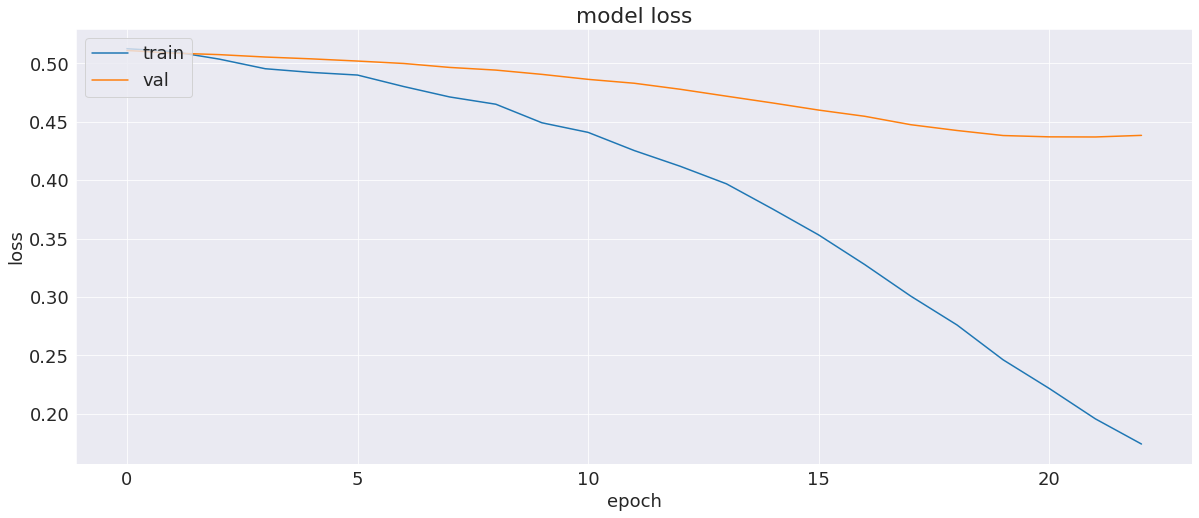

In [299]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

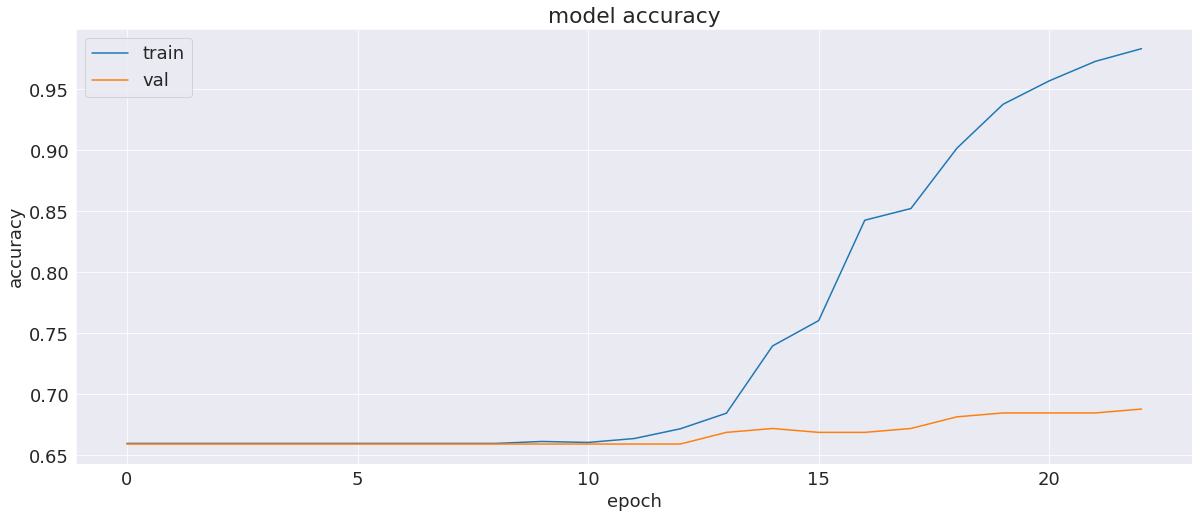

In [300]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [301]:
y_pred = model.predict(X_test)
cult = [int(x) for x in y_pred[:,0]>.6]


10/10 [==============================] - 0s 10ms/step


In [313]:
y_pred1 = y_pred.copy()
y_pred = model.predict(X_test)
print(sum(y_pred[:,0]>.6))

y_pred1[:,0] = [int(x) for x in y_pred[:,0]>.6]

print(sum(y_pred[:,1]>.26))
y_pred1[:,1] = [int(x) for x in y_pred[:,1]>.21]

print(sum(y_pred[:,2]>.33))
y_pred1[:,2] = [int(x) for x in y_pred[:,2]>.29]

y_pred2 = [1 if x[1]==1 else 2 if x[2]==1 else 0 for x in y_pred1]

10/10 [==============================] - 0s 10ms/step
232
15
67


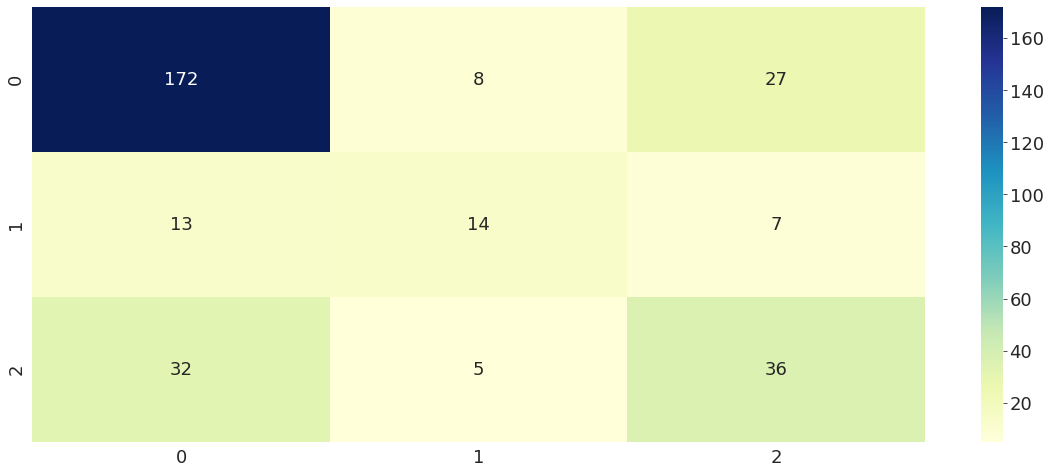

              precision    recall  f1-score   support

        Cult       0.79      0.83      0.81       207
  paranormal       0.52      0.41      0.46        34
    dramatic       0.51      0.49      0.50        73

    accuracy                           0.71       314
   macro avg       0.61      0.58      0.59       314
weighted avg       0.70      0.71      0.70       314



In [314]:
cm = confusion_matrix(y_test, y_pred2)
cm_matrix = pd.DataFrame(data=cm, )
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()
print(classification_report(y_test, y_pred2, target_names=['Cult', 'paranormal', 'dramatic']))

In [316]:
model.save('../Model weights/transformer_weights.h5')